# Post-processing for jet in coflow
This script processes the Nalu data probes from the variable density jet in coflow calculation. For the values of number of axial, radial and azimuthal data probes, please see the input file. The probes are in the locations of Charonko and Presteridge (2017): <https://doi.org/10.1017/jfm.2017.379>

**Note:** 
1. There is variable reuse across datasets; to avoid pollution of namespace, run the cells immediately below the probe of interest.
2. The output files can have multiple timesteps; the script selects the latest.

In [113]:
import numpy as np
import matplotlib.pyplot as plt

In [114]:
data       = np.loadtxt('axial_avg_fa.dat', skiprows=1)
time_steps = len(np.unique(data[:,0]))
ax_points  = 1024  # number of axial points (input.i: data_probes)
az_points  = 64    # number of azimuthal points 
rd_points  = 1024  # number of radial points

## Streamwise velocity axial variation

In [115]:
data = np.loadtxt('axial_avg_fa.dat', skiprows=1)
print(np.shape(data))

(3072, 8)


In [116]:
X = np.linspace(1.415,.415,ax_points)
X = (X-.415)/0.011
U = data[:,-3]
U = U/27.7

(-4.545454545454546,
 95.45454545454547,
 -0.008033916967509033,
 1.2881786823104693)

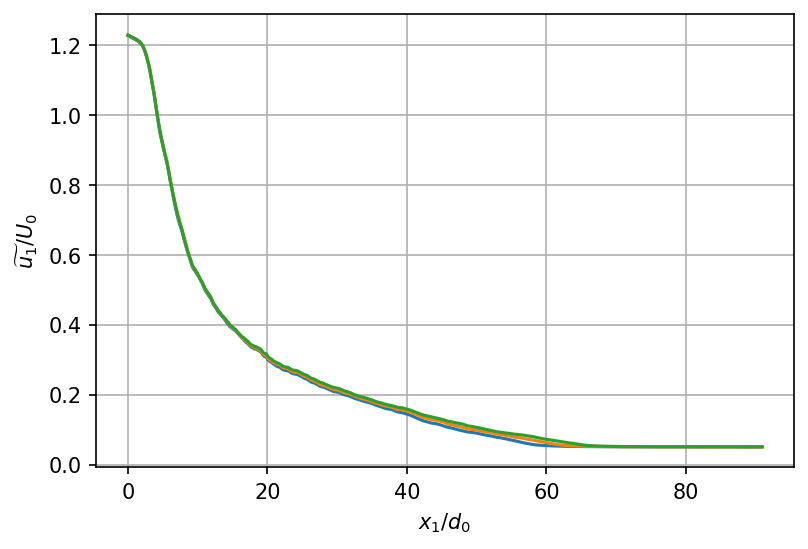

In [117]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1)
for _ in range(time_steps):
    ax.plot(X,U[ax_points*_:ax_points*(_+1)])
ax.grid()
ax.set_xlabel('$x_1 / d_0$')
ax.set_ylabel('$\widetilde{u_1}/ {U_0}$')
plt.axis('tight')
#plt.savefig('ax_v.png', dpi=300)

## Pipe velocity profile

In [119]:
data = np.loadtxt('pipe_full_ring.dat', skiprows=1)
print(np.shape(data))

(196608, 8)


In [120]:
U = data[:,-3]

# average over ring
U_last = U[int(-len(U)/time_steps):]
U_avg = np.zeros(rd_points)
for i in range(rd_points):
    U_avg[i] = (np.mean(U_last[i*az_points:(i+1)*az_points-1]))/27.7
    
X = (np.linspace(0, 0.0055, rd_points))/0.011
print('The average velocity is', np.trapz(U_avg*27.7)/(len(U_avg)))

The average velocity is 30.197206357158354


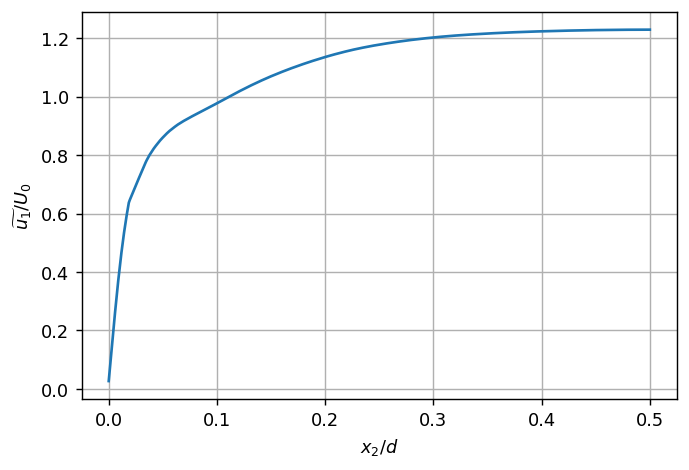

In [105]:
fig = plt.figure(dpi=128)
ax  = fig.add_subplot(1,1,1)
ax.plot(X, np.flip(U_avg))
ax.set_xlabel('$x_2/d$')
ax.set_ylabel('$\widetilde{u_1}/ {U_0}$')
ax.grid()
plt.savefig('ring_avg.png',dpi=300)

## Streamwise velocity axial variation

In [106]:
data1 = np.loadtxt('coflow_full_ring_fa.dat', skiprows=1)
data2 = np.loadtxt('coflow_full_ring_fa_2.dat', skiprows=1)
data3 = np.loadtxt('coflow_full_ring_fa_3.dat', skiprows=1)
data = np.stack(((data1, data2, data3)))
print(np.shape(data))

(3, 196608, 8)


In [107]:
U_avg = np.zeros((3,ax_points))

for j in range(3):
    U = data[j,:,-3]
    U_last = U[-int(len(U)/time_steps):] # extract last timestep data
    for i in range(ax_points):
        U_avg[j,i] = (np.mean(U_last[i*az_points:(i+1)*az_points-1]))   
        
X = (np.linspace(0, 0.265, rd_points))

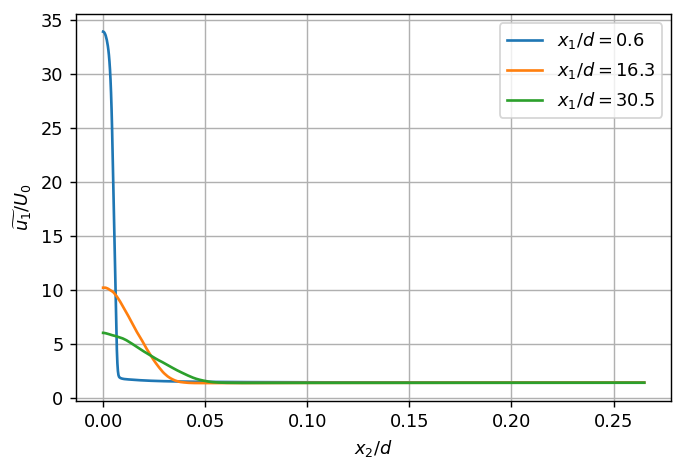

In [108]:
fig = plt.figure(dpi=128)
ax  = fig.add_subplot(1,1,1)
ax.plot(X,np.flip(U_avg[0,:]),label='$x_1/d = 0.6$')  # flip velocity array to align with x
ax.plot(X,np.flip(U_avg[1,:]),label='$x_1/d = 16.3$')
ax.plot(X,np.flip(U_avg[2,:]),label='$x_1/d = 30.5$')
ax.set_xlabel('$x_2/d$')
ax.set_ylabel('$\widetilde{u_1}/ {U_0}$')
#ax.set_xlim([0,5])
ax.grid()
ax.legend()
plt.savefig('coflow_ring_avg.png',dpi=300)

The self-similar normalization from Charonko and Presteridge (Figure 7) is used. The scaling for velocity is as follows

$$ \frac{\tilde{u}_1 - \tilde{u}_{\infty}}{\tilde{u}_{1,CL} - \bar{u}_{\infty}} $$

and for length it is $$\frac{x_2}{r_{\tilde{u}_{1/2}}}$$



In [109]:
r_half     = np.zeros(3)
u_fa_infty = np.zeros(3)
u_fa_cl    = np.zeros(3)
u_ra_infty = np.zeros(3)
U_ss       = np.zeros((3,ax_points))
X_ss       = np.zeros((3,ax_points))

for j in range(3):
    r_half[j] = (ax_points - np.argmin(np.abs(U_avg[j,:] - U_avg[j,-1]/2)))/ax_points *.265
    u_fa_infty[j] = U_avg[j,0]
    u_fa_cl[j] = U_avg[j,-1]
    u_ra_infty[j] = u_fa_infty[j] # approximation to avoid loading ra data
    U_ss[j,:] = (U_avg[j,:] - u_fa_infty[j])/(u_fa_cl[j] - u_fa_infty[j])
    X_ss[j,:] = X/r_half[j]

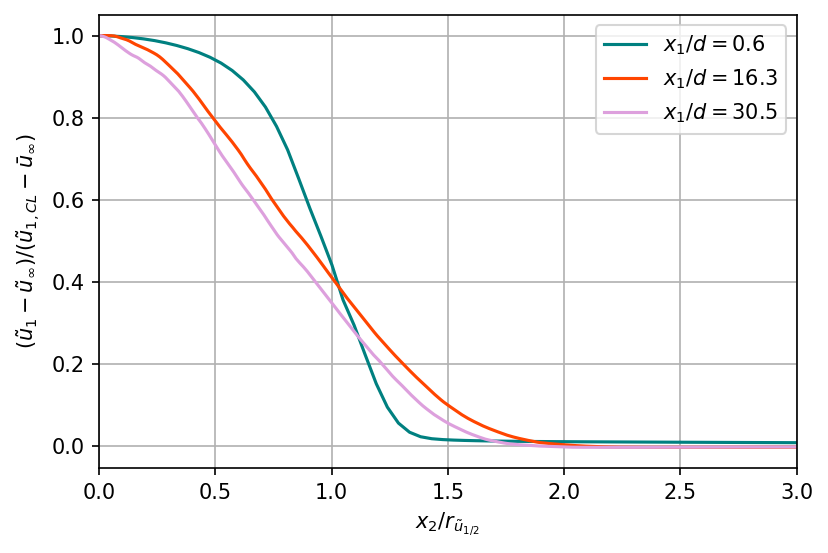

In [110]:
fig = plt.figure(dpi=150)
ax  = fig.add_subplot(1,1,1)

ax.plot(X_ss[0,:], np.flip(U_ss[0,:]), 'teal', label='$x_1/d = 0.6$')
ax.plot(X_ss[1,:], np.flip(U_ss[1,:]), 'orangered', label='$x_1/d = 16.3$')
ax.plot(X_ss[2,:], np.flip(U_ss[2,:]), 'plum', label='$x_1/d = 30.5$')
ax.set_xlim([0,3])
ax.set_ylabel('$(\\tilde{u}_1 - \\tilde{u}_{\infty})/(\\tilde{u}_{1,CL} - \\bar{u}_{\infty}$)')
ax.set_xlabel('$x_2/r_{\\tilde{u}_{1/2}}$')
ax.legend()
ax.grid()
#plt.savefig('fig7a.png',dpi=300)

## Experimental data

In [91]:
e1 = np.loadtxt('./data/Velocity1.5.txt')
e2 = np.loadtxt('./data/Velocity16.2d.txt')
e3 = np.loadtxt('./data/Velocity3.3d.txt')
e4 = np.loadtxt('./data/Velocity30.2d.txt')

print(np.shape(data))

(32, 2)


In [92]:
np.max(e1)

28.6111111111111

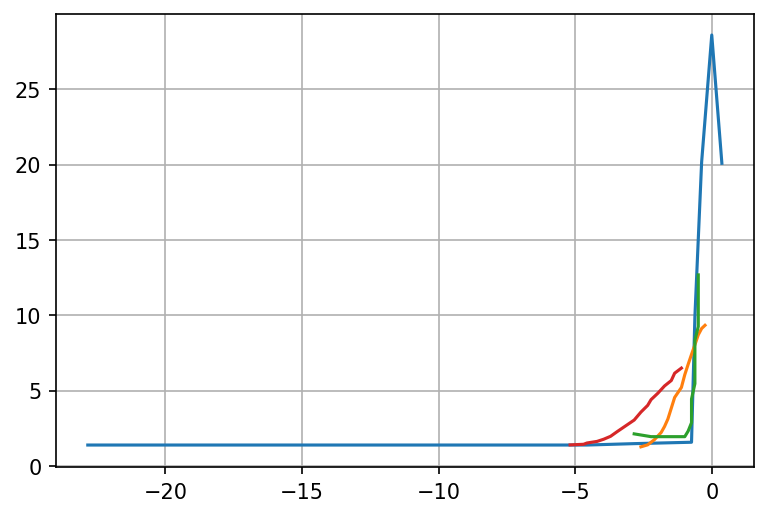

In [89]:
fig = plt.figure(dpi=150)
ax  = fig.add_subplot(1,1,1)
ax.plot(data1[:int(len(data1)/2),0],data1[:int(len(data1)/2),1])
ax.plot(data2[:int(len(data1)/2),0],data2[:int(len(data1)/2),1])
ax.plot(data3[:int(len(data1)/2),0],data3[:int(len(data1)/2),1])
ax.plot(data4[:int(len(data1)/2),0],data4[:int(len(data1)/2),1])
ax.grid()